In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import pprint
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def plot_price_series(df, ts1, ts2):
    months = mdates.MonthLocator()  # every month
    fig, ax = plt.subplots()
    ax.plot(df.index, df[ts1], label=ts1)
    ax.plot(df.index, df[ts2], label=ts2)
    plt.xlabel('Month/Year')
    plt.ylabel('Price ($)')
    plt.title('%s and %s Daily Prices' % (ts1, ts2))
    plt.legend()
    plt.show()

def plot_scatter_series(df, ts1, ts2):
    plt.xlabel('%s Price ($)' % ts1)
    plt.ylabel('%s Price ($)' % ts2)
    plt.title('%s and %s Price Scatterplot' % (ts1, ts2))
    plt.scatter(df[ts1], df[ts2])
    plt.show()

def plot_residuals(df):
    months = mdates.MonthLocator()  # every month
    fig, ax = plt.subplots()
    ax.plot(df.index, df["res"], label="Residuals")
    ax.grid(True)
    plt.title('Residual Plot')
    plt.legend()
    plt.plot(df["res"])
    plt.show()

# CADF Using Log Returns of SGD & USD

In [2]:
#read in csv of currency data 
curr = pd.read_csv('Currencies.csv', index_col=0, parse_dates=True)

#create new dataframe and store log returns for each currency 
lncurr = pd.DataFrame()
lncurr['LNUSD'] = (np.log(curr['FXRUSD'])- np.log(curr['FXRUSD'].shift(1))).dropna()
lncurr['LNSD'] = (np.log(curr['FXRSD'])- np.log(curr['FXRSD'].shift(1))).dropna()

#OLS regression to find Beta 
model = sm.OLS(lncurr['LNUSD'], lncurr['LNSD']).fit()
model_details = model.summary()
print(model_details)

                                 OLS Regression Results                                
Dep. Variable:                  LNUSD   R-squared (uncentered):                   0.729
Model:                            OLS   Adj. R-squared (uncentered):              0.728
Method:                 Least Squares   F-statistic:                              2688.
Date:                Tue, 03 Dec 2019   Prob (F-statistic):                   9.16e-286
Time:                        09:41:05   Log-Likelihood:                          4295.7
No. Observations:                1002   AIC:                                     -8589.
Df Residuals:                    1001   BIC:                                     -8584.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [3]:
beta = model.params
beta

LNSD    1.130495
dtype: float64

In [4]:
beta = 1.1305
lncurr['res'] = lncurr['LNUSD'] - beta * lncurr['LNSD']
cadf = ts.adfuller(lncurr['res'])
pprint.pprint(cadf)

(-24.709660161329104,
 0.0,
 1,
 1000,
 {'1%': -3.4369061654329998, '10%': -2.568311209, '5%': -2.86443457404},
 -8383.657558795134)


### After performing the CADF test on the log returns of the series we get a test statistic of -24.7 which is less than the 1% critical value meaning that the series is mean reverting  

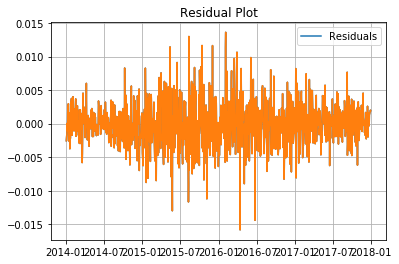

In [5]:
plot_residuals(lncurr)

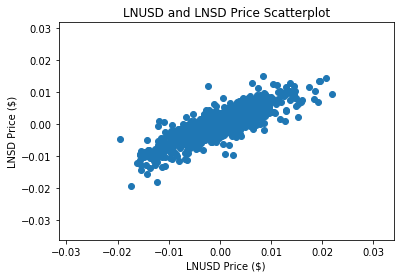

In [6]:
plot_scatter_series(lncurr, 'LNUSD', 'LNSD')


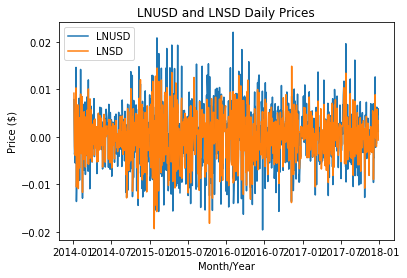

In [7]:
plot_price_series(lncurr, 'LNUSD', 'LNSD')

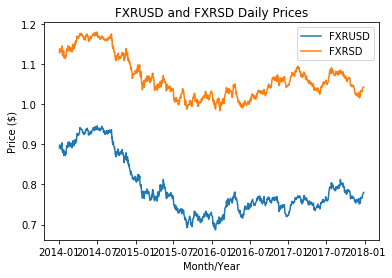

In [8]:
plot_price_series(curr, 'FXRUSD', 'FXRSD')

# Using just the price series 

In [9]:
curr.head()

,FXRUSD,FXRSD,FXRHKD
Date,,,
2014-01-02,0.8912,1.1277,6.9107
2014-01-03,0.8982,1.1381,6.9648
2014-01-06,0.8949,1.1358,6.9395
2014-01-07,0.8920,1.1325,6.9169
2014-01-08,0.8931,1.1345,6.9254


In [10]:
#OLS regression to find Beta 
model = sm.OLS(curr['FXRUSD'], curr['FXRSD']).fit()
model_details = model.summary()
print(model_details)

                                 OLS Regression Results                                
Dep. Variable:                 FXRUSD   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          5.178e+05
Date:                Tue, 03 Dec 2019   Prob (F-statistic):                        0.00
Time:                        09:41:06   Log-Likelihood:                          1941.3
No. Observations:                1003   AIC:                                     -3881.
Df Residuals:                    1002   BIC:                                     -3876.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [11]:
beta = 1.1305
curr['res'] = curr['FXRUSD'] - beta * curr['FXRSD']
cadf = ts.adfuller(curr['res'])
pprint.pprint(cadf)

(-2.046064373831838,
 0.26674760417125554,
 2,
 1000,
 {'1%': -3.4369061654329998, '10%': -2.568311209, '5%': -2.86443457404},
 -8627.66801654902)


### Here we see that using just the raw price series the test statistic reads -2.04 which is greater than the 10% critical value meaning  that the null hypothesis cannot be rejected 

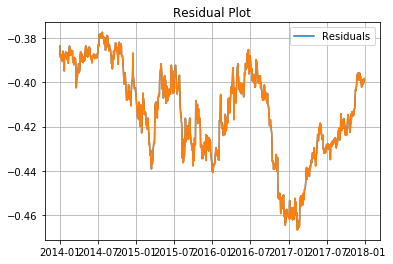

In [12]:
plot_residuals(curr)

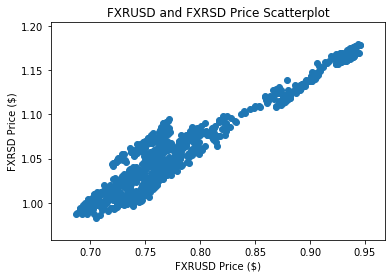

In [13]:
plot_scatter_series(curr, 'FXRUSD', 'FXRSD')

### Conclusion price series isn't mean reverting but log returns on the price series is... 

article on cointegration with log prices: http://epchan.blogspot.com/2013/11/cointegration-trading-with-log-prices.html 